In [1]:
import os
files = os.listdir('../../pythia/results/bias-evals/')

In [2]:
import json
def read_file(f):
    with open('../../pythia/results/bias-evals/' + f, 'r') as f:
        return json.load(f)

In [3]:
def parse_json(f):
    data = read_file(f)
    # get all values where key contains 'english' in a new dict 
    english = {k: v for k, v in data['results'].items() if 'english' in k}
    # get only the pct_stereotype key from the new dict
    english = {k: v['pct_stereotype'] for k, v in english.items()}
    return english

In [4]:
parse_json(r'pythia-1.3b-deduped-step69000_eval_results_01-22-2023-09-20-33.json')

{'crows_pairs_english_gender': 0.61875,
 'crows_pairs_english': 0.6118067978533095}

In [5]:
pythia_files = []
intervened_files = []
long_intervened_files = []
for f in files:
  if f.startswith('pythia'):
    pythia_files.append(f)
  elif f.startswith('intervention'):
    intervened_files.append(f)
  elif f.startswith('long-intervention'):
    long_intervened_files.append(f)

In [6]:
pythia_res = {}
intervened_res = {}
long_intervened_res = {}

In [7]:
sizes_pythia = []
for f in pythia_files:
    split_name = f.split('-')
    sizes_pythia.append(split_name[1])
sizes_pythia = list(set(sizes_pythia))

steps_pythia = []
for f in pythia_files:
    split_name = f.split('-')
    if split_name[1] == '350m':
        if split_name[2] != 'deduped':
            continue
    if split_name[1] == '6.9b':
        steps_pythia.append(int(split_name[2].split('_')[0][4:]))
        continue
    steps_pythia.append(int(split_name[3].split('_')[0][4:]))
steps_pythia = list(set(steps_pythia))

sizes_intervened = []
for f in intervened_files:
    split_name = f.split('-')
    sizes_intervened.append(split_name[1])
sizes_intervened = list(set(sizes_intervened))

steps_intervened = []
for f in intervened_files:
    split_name = f.split('-')
    if split_name[1] == '6.9b':
        steps_intervened.append(int(split_name[2].split('_')[0][4:]))
        continue
    steps_intervened.append(int(split_name[3].split('_')[0][4:]))
steps_intervened = list(set(steps_intervened))

sizes_long_intervened = []
for f in long_intervened_files:
    split_name = f.split('-')
    sizes_long_intervened.append(split_name[2])
sizes_long_intervened = list(set(sizes_long_intervened))

steps_long_intervened = []
for f in long_intervened_files:
    split_name = f.split('-')
    step = int(split_name[4].split('_')[0][4:])
    steps_long_intervened.append(step)
steps_long_intervened = list(set(steps_long_intervened))

In [8]:
task_names = ['crows_pairs_english_gender']

In [9]:
sizes_pythia

['19m', '1.3b', '350m', '6.9b']

In [10]:
pythia_files[0].split('-')

['pythia',
 '1.3b',
 'deduped',
 'step11500_eval_results_01',
 '20',
 '2023',
 '14',
 '41',
 '42.json']

In [11]:
for sizes in sizes_pythia:
    for f in pythia_files:
        file_split = f.split('-')
        if file_split[1] == '350m':
            if file_split[2] != 'deduped':
                continue
        if file_split[1] == '6.9b':
            step = int(file_split[2].split('_')[0][4:])
        else:
            step = int(file_split[3].split('_')[0][4:])
        if file_split[1] == sizes:
            pythia_res[(sizes, step)] = parse_json(f)

In [12]:
for sizes in sizes_intervened:
    for f in intervened_files:
        file_split = f.split('-')
        if file_split[1] == '6.9b':
            step = int(file_split[2].split('_')[0][4:])
        else:
            step = int(file_split[3].split('_')[0][4:])
        if file_split[1] == sizes:
            intervened_res[(sizes, step)] = parse_json(f)

In [13]:
for sizes in sizes_long_intervened:
    for f in long_intervened_files:
        file_split = f.split('-')
        step = int(file_split[4].split('_')[0][4:])
        if file_split[2] == sizes:
            long_intervened_res[(sizes, step)] = parse_json(f)

In [49]:
# Plot the results
import matplotlib.pyplot as plt
import numpy as np

def plot_results(pythia_dict, intervened_dict, task_name, model_size, save_name, connect=True):
    ls_pythia = []
    ls_intervened = []
    # plot pythia
    for key in pythia_dict:
        if key[0] == model_size:
            ls_pythia.append((key[1], pythia_dict[key][task_name]))
    # Sort by step
    ls_pythia = sorted(ls_pythia, key=lambda x: x[0])
    # plot intervened
    for key in intervened_dict:
        if key[0] == model_size:
            ls_intervened.append((key[1], intervened_dict[key][task_name]))
    # Sort by step
    ls_intervened = sorted(ls_intervened, key=lambda x: x[0])
    # Find first step where intervened matches pythia in x[0]
    c = 0
    for i in range(len(ls_pythia)):
        if ls_pythia[i][0] >= ls_intervened[0][0]:
            c = i
            break
    c -= 1
    if connect:
        # Add the point at index c to the beginning of ls_intervened
        # print('Adding point', ls_pythia[c], 'to ls_intervened')
        ls_intervened = [ls_pythia[c]] + ls_intervened
    # plot
    plt.plot([x[0] for x in ls_pythia], [x[1] for x in ls_pythia], label='Pythia')
    plt.plot([x[0] for x in ls_intervened], [x[1] for x in ls_intervened], label='Intervened')
    plt.xlabel('Steps')
    plt.ylabel('Pct stereotype')
    # plt.title('Pct stereotype for ' + task_name + ' for model size ' + model_size)
    plt.legend()
    plt.show()
    # plt.savefig(save_name)

In [50]:
def plot_results_with_both_interventions(pythia_dict, intervention_dict, long_intervention_dict, task_name, model_size, save_name, connect=True):
    ls_pythia = []
    ls_intervention = []
    ls_long_intervention = []
    # plot pythia
    for key in pythia_dict:
        if key[0] == model_size:
            ls_pythia.append((key[1], pythia_dict[key][task_name]))
    # Sort by step
    ls_pythia = sorted(ls_pythia, key=lambda x: x[0])
    # plot intervention
    for key in intervention_dict:
        if key[0] == model_size:
            ls_intervention.append((key[1], intervention_dict[key][task_name]))
    # Sort by step
    ls_intervention = sorted(ls_intervention, key=lambda x: x[0])
    # plot long intervention
    for key in long_intervention_dict:
        if key[0] == model_size:
            ls_long_intervention.append((key[1], long_intervention_dict[key][task_name]))
    # Sort by step
    ls_long_intervention = sorted(ls_long_intervention, key=lambda x: x[0])

    # Find first step where intervened matches pythia in x[0]
    c1 = 0
    for i in range(len(ls_pythia)):
        if ls_pythia[i][0] >= ls_intervention[0][0]:
            c1 = i
            break
    c1 -= 1
    c2 = 0
    for i in range(len(ls_pythia)):
        if ls_pythia[i][0] >= ls_long_intervention[0][0]:
            c2 = i
            break
    c2 -= 1
    if connect:
        # Add the point at index c to the beginning of ls_intervened
        # print('Adding point', ls_pythia[c], 'to ls_intervened')
        ls_intervention = [ls_pythia[c1]] + ls_intervention
        ls_long_intervention = [ls_pythia[c2]] + ls_long_intervention

    # plot
    plt.plot([x[0] for x in ls_pythia], [x[1] for x in ls_pythia], label='Pythia')
    plt.plot([x[0] for x in ls_intervention], [x[1] for x in ls_intervention], label='Intervention')
    plt.plot([x[0] for x in ls_long_intervention], [x[1] for x in ls_long_intervention], label='Long Intervention')
    plt.xlabel('Steps')
    plt.ylabel('Pct stereotype')
    # plt.title('Pct stereotype for ' + task_name + ' for model size ' + model_size)
    plt.legend()
    plt.show()
    # Save the plot
    # plt.savefig(save_name)

Plotting crows_pairs_english_gender 19m


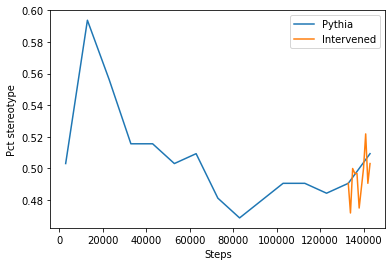

Plotting crows_pairs_english_gender 1.3b


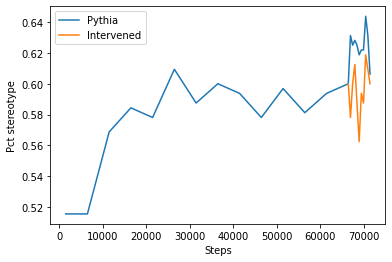

Plotting crows_pairs_english_gender 350m


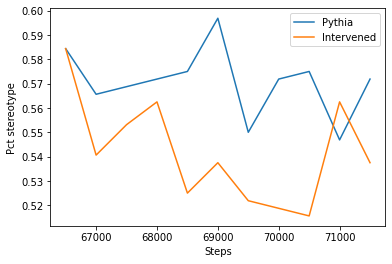

Plotting crows_pairs_english_gender 6.9b


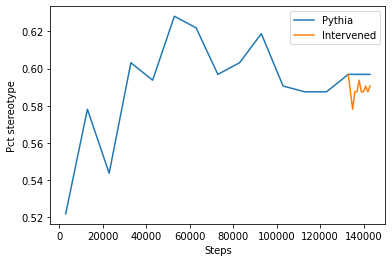

In [51]:
# Make all plots
for task in task_names:
    for size in sizes_pythia:
        print('Plotting', task, size)
        plot_results(pythia_res, intervened_res, task, size, 'memorization_plots/' + task + '_' + size + '_intervened.png')

Plotting crows_pairs_english_gender 1.3b


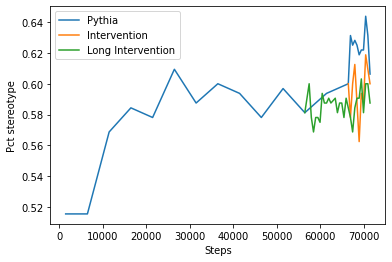

In [52]:
for task in task_names:
    for size in sizes_long_intervened:
        print('Plotting', task, size)
        plot_results_with_both_interventions(pythia_res, intervened_res, long_intervened_res, task, size,
                                                'memorization_plots/' + task + '_' + size + '_long_intervened.png')

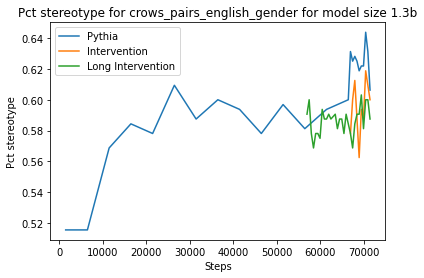

In [48]:
for task in task_names:
    for size in sizes_long_intervened:
        plot_results_with_both_interventions(pythia_res, intervened_res, long_intervened_res, task, size,
                                                'memorization_plots/' + task + '_' + size + '_long_intervened.png', False)